In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries

In [80]:
data = pd.read_csv('../data/raw/Realisierte_Erzeugung_201804010000_202303312359_Stunde.csv', delimiter=";", nrows=1500)

# Function to convert German number notation to float
def convert_to_float(german_number_str):
    try:
        return float(german_number_str.replace('.', '').replace(',', '.'))
    except ValueError:
        return None

# Convert "Datum" column to datetime
data['Datum'] = pd.to_datetime(data['Datum'], format='%d.%m.%Y')

# Convert "Anfang" and "Ende" columns to time
data['Anfang'] = pd.to_datetime(data['Anfang'], format='%H:%M').dt.time
data['Ende'] = pd.to_datetime(data['Ende'], format='%H:%M').dt.time

# Convert energy columns to float
energy_columns = [col for col in data.columns if 'MWh' in col]
for col in energy_columns:
    data[col] = data[col].apply(convert_to_float)

# Combine "Datum" and "Anfang" into a single datetime column
data['Timestamp'] = pd.to_datetime(data['Datum'].astype(str) + ' ' + data['Anfang'].astype(str))

# Drop the "Datum", "Anfang", and "Ende" columns
data = data.drop(columns=['Datum', 'Anfang', 'Ende'])

# Reorder columns to have "Timestamp" as the first column
data = data[['Timestamp'] + [col for col in data.columns if col != 'Timestamp']]

# Define new column names
new_column_names = {
    'Timestamp': 'timestamp',
    'Biomasse [MWh] Berechnete Auflösungen': 'biomass_mwh',
    'Wasserkraft [MWh] Berechnete Auflösungen': 'hydropower_mwh',
    'Wind Offshore [MWh] Berechnete Auflösungen': 'wind_offshore_mwh',
    'Wind Onshore [MWh] Berechnete Auflösungen': 'wind_onshore_mwh',
    'Photovoltaik [MWh] Berechnete Auflösungen': 'photovoltaic_mwh',
    'Sonstige Erneuerbare [MWh] Berechnete Auflösungen': 'other_renewables_mwh',
    'Kernenergie [MWh] Berechnete Auflösungen': 'nuclear_mwh',
    'Braunkohle [MWh] Berechnete Auflösungen': 'brown_coal_mwh',
    'Steinkohle [MWh] Berechnete Auflösungen': 'hard_coal_mwh',
    'Erdgas [MWh] Berechnete Auflösungen': 'natural_gas_mwh',
    'Pumpspeicher [MWh] Berechnete Auflösungen': 'pumped_storage_mwh',
    'Sonstige Konventionelle [MWh] Berechnete Auflösungen': 'other_conventional_mwh'
}

# Rename the columns
data.rename(columns=new_column_names, inplace=True)

# Some timestamps are duplicates, remove them
data = data.drop_duplicates(subset='timestamp')

# Pytorch throws an error on M1/M2 Macbooks with float64
for column in data.select_dtypes(include=['float64']).columns:
    data[column] = data[column].astype('float32')

# Display the first few rows of the modified dataframe
data.head()

,timestamp,biomass_mwh,hydropower_mwh,wind_offshore_mwh,wind_onshore_mwh,photovoltaic_mwh,other_renewables_mwh,nuclear_mwh,brown_coal_mwh,hard_coal_mwh,natural_gas_mwh,pumped_storage_mwh,other_conventional_mwh
0,2018-04-01 00:00:00,4643.25,1685.50,1557.50,7364.25,0.0,239.00,9047.25,12489.25,2717.75,3347.75,1385.75,1324.25
1,2018-04-01 01:00:00,4606.75,1685.75,1326.00,8377.25,0.0,239.25,8749.00,11914.75,2384.00,3186.75,309.00,1320.00
2,2018-04-01 02:00:00,4597.25,1682.50,1204.25,9609.75,0.0,239.50,8453.50,11664.25,2195.75,3102.50,26.75,1301.25
3,2018-04-01 03:00:00,4587.50,1672.00,1103.00,10765.50,0.0,240.00,8152.25,10850.25,2199.75,3051.00,19.75,1279.50
4,2018-04-01 04:00:00,4604.00,1668.00,1015.00,11903.75,0.0,239.00,7892.25,10496.00,2203.75,3063.00,93.50,1286.50


In [65]:
data.dtypes

timestamp                 datetime64[ns]
biomass_mwh                      float32
hydropower_mwh                   float32
wind_offshore_mwh                float32
wind_onshore_mwh                 float32
photovoltaic_mwh                 float32
other_renewables_mwh             float32
nuclear_mwh                      float32
brown_coal_mwh                   float32
hard_coal_mwh                    float32
natural_gas_mwh                  float32
pumped_storage_mwh               float32
other_conventional_mwh           float32
dtype: object

In [81]:
# Create a TimeSeries object from the Darts package
series = TimeSeries.from_dataframe(data, time_col="timestamp", value_cols="biomass_mwh", freq='1h')

<Axes: xlabel='timestamp'>

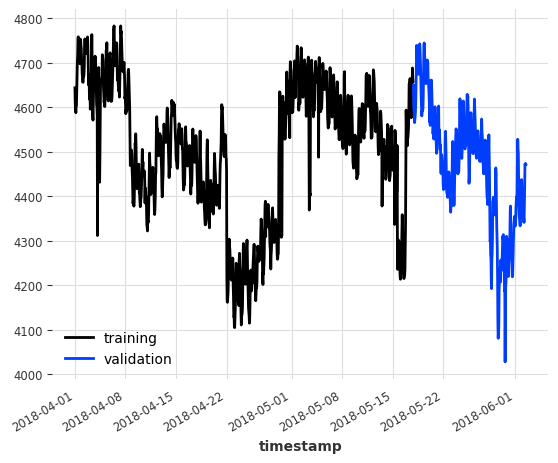

In [82]:
# Get the first 75% of the series as training data and the rest as validation data
split_index = int(len(series) * 0.75)
split_date = series.time_index[split_index]

# Create Train-Validation split
CUTOFF_DATE = split_date

train, val = series.split_before(pd.Timestamp(CUTOFF_DATE))
train.plot(label="training")
val.plot(label="validation")

In [83]:
# We want to predict the length of the validation set into the future
PREDICTION_LENGTH = len(val)

<Axes: xlabel='timestamp'>

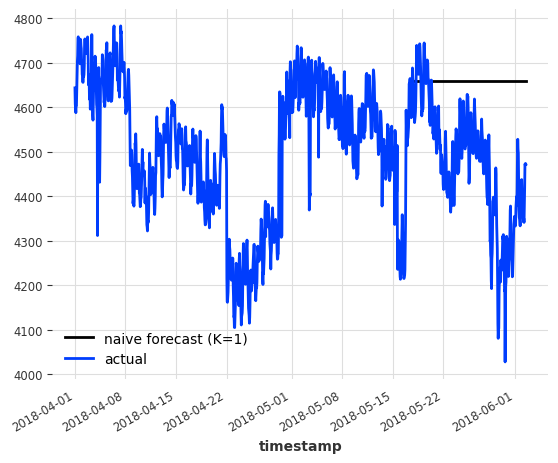

In [84]:
# Create a very naive model, which just repeats last value of the training set

from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(PREDICTION_LENGTH)

naive_forecast.plot(label="naive forecast (K=1)")
series.plot(label="actual")

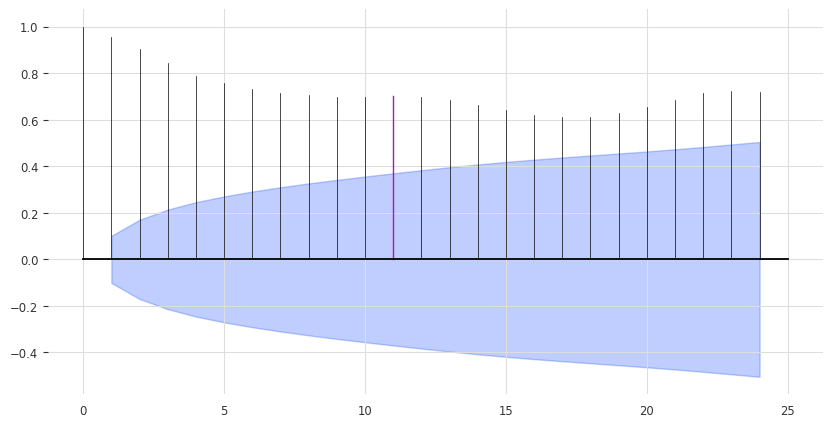

In [69]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=11, alpha=0.05)

In [70]:


for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.5)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 11.
There is seasonality of order 23.


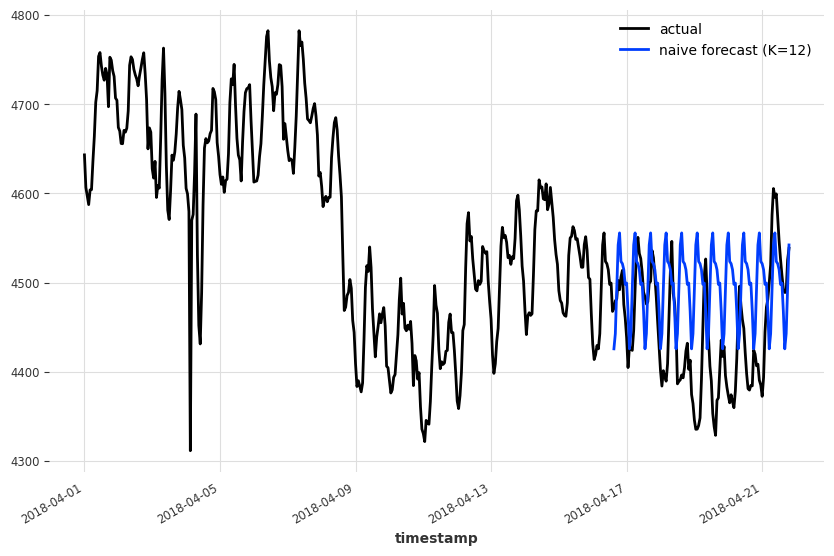

In [71]:
import matplotlib.pyplot as plt

seasonal_model = NaiveSeasonal(K=11)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(PREDICTION_LENGTH)

plt.figure(figsize=(10,6))
series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

#plt.xlim(pd.Timestamp('2018-05-18'), pd.Timestamp('2018-06-23'))
plt.show()

<Axes: xlabel='timestamp'>

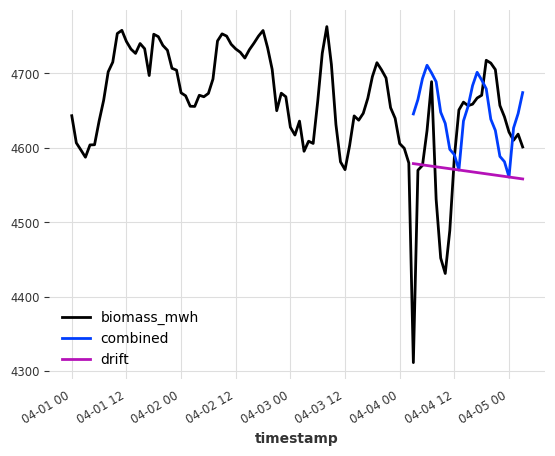

In [44]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(PREDICTION_LENGTH)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [45]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 1.77%.


In [46]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

In [48]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, seasonal_forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 1.80%
model TBATS() obtains MAPE: 1.80%
model AutoARIMA() obtains MAPE: 1.80%
model Theta() obtains MAPE: 1.80%


In [49]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [50]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 1.39, with theta = 0.16326530612244916.


<Axes: xlabel='timestamp'>

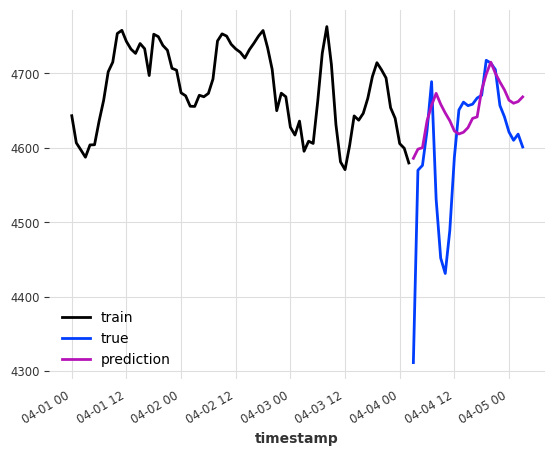

In [51]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

<Axes: xlabel='timestamp'>

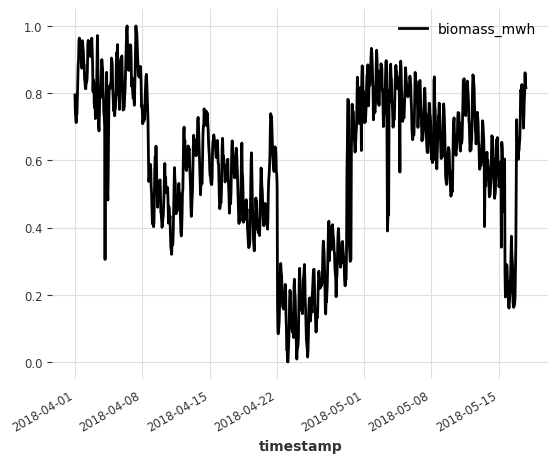

In [85]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_scaled = scaler.fit_transform(train)

train_scaled.plot()

In [88]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(train_scaled, epochs=15, verbose=True);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s, train_loss=0.00566]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s, train_loss=0.00566]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


<Axes: xlabel='timestamp'>

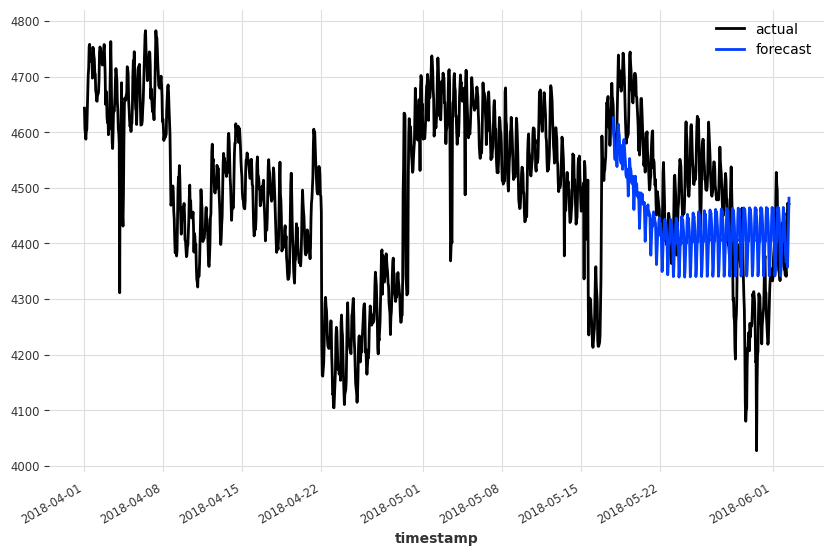

In [89]:
pred = model.predict(series=train_scaled, n=PREDICTION_LENGTH)

pred = scaler.inverse_transform(pred)

plt.figure(figsize=(10, 6))
series.plot(label="actual")
pred.plot(label="forecast")

In [90]:
mape(val, pred)

2.4175966158509254